In [2]:
%matplotlib inline

from __future__ import division, print_function

import glob as glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import optimize

sns.set_style('white')

### Set parameters

In [3]:
N_samples = 10000
threshold = .5 #threshold to pass to reach "success"
REWARD = 1


### Free parameters to fit (later on)

In [4]:
#COST = 0.5
#B=6
#A=60 
#u_skill = .625 #mean of beta
#tao_skill = 20 #variance of beta

### Functions

In [5]:
def prob_reward(e,diff,skill, A, B):
    """Return the probability of getting the reward
    
    Parameters
    ----------
    e : numeric or array-like
        Description of parameter 'effort'
    diff: numeric or array-like 
        Description of parameter 'difficulty"
    skill: numeric or array-like 
        Description of parameter 'skill"
    A: numeric parameter that moves
        Function left and right
    B: numeric parameter than changes
        Sharpness of function
    
    Returns
    -------
    Numeric or array-like value of probabilty of getting a reward between 0-1
    ...
    """
    return 1/(1 + A * np.exp(-(e * skill / diff) * B)) ##plot for different As (moves function around) and Bs (changes sharpness)


def get_effort_multidim(cost, diff, skill, A, B, reward=1):
    """Function that returns optimal effort given different skills and difficulties.
    Runs utility function of the form utility = reward* probability of getting
    reward - cost* effort 
    Cost is set but scales with effort
    Reward is set but scales with probability of getting it
    This function finds the argmax value of utility and returns that as the 
    'optimal' effort that should be exerted given some difficuly, skill, cost, and reward.
    

    Parameters
    ----------
    cost : numeric description of 'cost'
    diff: numeric or array-like 
        Description of parameter 'difficulty'
    skill: numeric or array-like 
        Description of parameter 'skill'
    A: numeric parameter that moves
        Function left and right
    B: numeric parameter than changes
        Sharpness of function
    reward: numeric set to 1 for 'reward'

    Returns
    -------
    Ndarray of effort with same shape as `diff` and `skill`.
    """
    es = np.linspace(0, 1, 100)
    es_rank2 = es[np.newaxis, ...]
    
    try:
        diff = diff[..., np.newaxis]
    except TypeError:
        pass
    try:
        skill = skill[..., np.newaxis]
    except TypeError:
        pass
    
    prob = prob_reward(e=es_rank2, diff=diff, skill=skill, A=A, B=B)
    utilities = reward * prob - cost * es_rank2
    return es[utilities.argmax(-1)]



def create_priors_opt(n_samples, tao_skill, u_skill, cost, A, B, diff, reward=1, 
                      effort_threshold=0.5):
    """Model for creating priors of skill at different effort and success thresholds
    
    Parameters
    ----------
    n_samples : int of number of samples
        You want to run
    tao_skill: numeric, variance of skill beta function
    u_skill: numeric, mean of skill beta function
    cost : numeric of cost number
    A : numeric scaling variable for "prob_reward"
        That moves function left or right
    B : numeric scaling variable for "prob_reward" 
        That sharpens peak of function
    diff: numeric or array-like parameter
        of difficulty
    reward : numeric value of reward
    effort_threshold: threshold that determines boundry
        Between high and low effort
    
    Returns
    -------
    Ndarray of skill, success trials, and high effort trials
    """
    # Skill and diff are beta distributions.
    skills = np.random.beta(
        tao_skill * u_skill, (1 - u_skill) * tao_skill, size=n_samples,
    )
    
    efforts = get_effort_multidim(
        cost=cost, skill=skills, diff=diff, A=A, B=B,
    )

    high_effort = efforts > effort_threshold
    success = prob_reward(efforts, diff, skills, A, B) > np.random.random(n_samples)

    return skills,  success, high_effort, efforts


def rmse(predictions, targets):
    """function for comparing model predictions to target data

    Parameters
    ----------
    predictions: array of model predictions
    targets: array of target data (human data)

    Returns
    -------
    numeric value of root mean squared fit of values
    """
    return np.sqrt(((predictions - targets) ** 2).mean())

## Plot Utility Functions

#### Variables I set --> free parameters

In [6]:
REWARD = 1
COST = .1
skilled = .8
unskilled = .4
hard = .8
easy = .2
A = 2
B = 9

#### First let's plot prob(reward) for varying levels of skill, effort, and difficulty

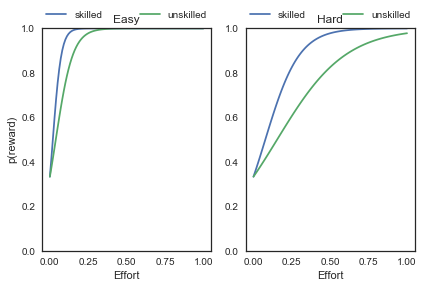

In [7]:
es=np.linspace(0,1,100)
p0 = [prob_reward(e,easy,unskilled, A, B) for e in es]
p1 = [prob_reward(e,easy,skilled,A, B) for e in es]

plt.subplot(1,2,1)
plt.plot(es, p1, label = "skilled")
plt.plot(es,p0, label = "unskilled")
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Effort') ; plt.ylabel('p(reward)'); plt.title('Easy')

p0 = [prob_reward(e,hard,unskilled,A, B) for e in es]
p1 = [prob_reward(e,hard,skilled,A, B) for e in es]
plt.subplot(1,2,2)
plt.plot(es, p1, label = "skilled")
plt.plot(es,p0,label = "unskilled")
plt.tight_layout()
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Effort') ;  plt.title('Hard')

Question for max - why does this function not start at prob reward = 0 when effort is 0??

#### Function that is similar to "get_effort_multidem" but simpiler for plotting purposes
* runs a utility function that finds the peak utility of "effort" for each combination of difficulty and skill

In [8]:
def get_effort(reward, cost, diff, skill):
    Us=list()
    es = np.linspace(0, 1, 100) 
    for i in es:
        U=reward*prob_reward(i, diff, skill, A, B)-cost*i #utility function
        Us.append(U)
    return es[np.argmax(Us)], Us, es  #return argmax of utility, and utilities 

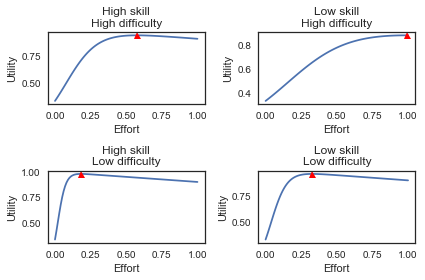

In [9]:
plt.subplot(2,2,1)
effort,Us,es=get_effort(REWARD,COST,hard,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('High skill\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,2)
effort,Us,es=get_effort(REWARD,COST,hard,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('Low skill\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,3)
effort,Us,es=get_effort(REWARD,COST,easy,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('High skill\nLow difficulty')
plt.tight_layout()

plt.subplot(2,2,4)
effort,Us,es=get_effort(REWARD,COST,easy,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('Low skill\nLow difficulty')
plt.tight_layout()

#### These plots capture our intutions about what should happen in each situation
* High skill, high difficulty: you should have to try pretty hard
* Low skill, high difficulty: you should have to try REALLY hard
* High skill, low difficulty: you shouldn't have to try very hard
* Low skill, low difficulty: you should have to try pretty hard

All things being equal, the rank of trying here from most to least is:
    1. low skill + high diff
    2. high skill + high diff
    3. low skill + low diff
    4. high skill + low diff

### Function that takes in free parameters and spits out model predictions

In [12]:
def run_model_opt(cost, A, B, u_skill, tao_skill, n_samples=10000):
    """function that takes in free parameters and returns model predictions (predicted skill)
    by condition (here split by high/low effort and high/low difficulty). In other words,
    Given some set of difficulty and effort, how skilled is this agent?

    Parameters
    ----------
    cost : numeric of cost number
    A : numeric scaling variable for "prob_reward"
        That moves function left or right
    B : numeric scaling variable for "prob_reward" 
        That sharpens peak of function
    tao_skill: numeric, variance of skill beta function
    u_skill: numeric, mean of skill beta function


    Returns
    -------
    means of skill calculated for each n_sample calculation done at a given difficulty
    and success level
    """
    
    np.random.seed(0)
    REWARD=1
    high_diff = .8 #arbitrarly set 
    low_diff = .2  #arbitrarly set 
    
    high_diff_skills, high_diff_success, high_diff_high_effort, effort_high_diff = create_priors_opt(
        n_samples =n_samples, tao_skill=tao_skill, u_skill=u_skill, cost=cost, A=A, B=B, diff = high_diff
    )

    low_diff_skills, low_diff_success, low_diff_high_effort, effort_low_diff = create_priors_opt(
        n_samples =n_samples, tao_skill=tao_skill, u_skill=u_skill, cost=cost, A=A, B=B, diff = low_diff
    )
    

    skill_high_diff_high_eff = high_diff_skills[high_diff_success & high_diff_high_effort]
    skill_high_diff_low_eff = high_diff_skills[high_diff_success & ~high_diff_high_effort]
    skill_low_diff_high_eff = low_diff_skills[low_diff_success & low_diff_high_effort]
    skill_low_diff_low_eff = low_diff_skills[low_diff_success & ~low_diff_high_effort]
    

    print  (np.mean(skill_high_diff_high_eff),np.mean(skill_high_diff_low_eff)) #low num, high num
    print (np.mean(skill_low_diff_high_eff),np.mean(skill_low_diff_low_eff)) #low num, medium num
    
    
    df = pd.DataFrame([{'cond': 'High Difficulty \n High Effort', 'post': s} for s in skill_high_diff_high_eff] +  
                  [{'cond': 'High Difficulty  \n Low Effort', 'post': s} for s in skill_high_diff_low_eff] +      
                  [{'cond': 'Low Difficulty  \n High Effort', 'post': s} for s in skill_low_diff_high_eff] +      
                  [{'cond': 'Low Difficulty  \n Low Effort', 'post': s} for s in skill_low_diff_low_eff])     

    
    return df


In [14]:
output= run_model_opt(cost = .1, A = 2, B = 9, u_skill = .5, tao_skill = 1,  n_samples=10000) #play with parameters
output.head()


0.531144218777 0.747864617097
0.109723551356 0.685901275738


,cond,post
0,High Difficulty \n High Effort,0.370615
1,High Difficulty \n High Effort,0.550306
2,High Difficulty \n High Effort,0.300812
3,High Difficulty \n High Effort,0.194055
4,High Difficulty \n High Effort,0.691438


In [15]:
df = pd.DataFrame(dict(cond=np.array(output["cond"]), post=output["post"]))
df.head()

,cond,post
0,High Difficulty \n High Effort,0.370615
1,High Difficulty \n High Effort,0.550306
2,High Difficulty \n High Effort,0.300812
3,High Difficulty \n High Effort,0.194055
4,High Difficulty \n High Effort,0.691438


In [53]:
#plot?
#sns.boxplot('cond', 'post', data = df)

In [17]:
def run_model_highdiff(cost, A, B, u_skill, tao_skill, n_samples=10000):
    """function that takes in free parameters and returns model predictions (predicted skill)
    when difficulty is high only and reward is achieved
    Parameters
    ----------
    """
    
    np.random.seed(0)
    REWARD=1
    high_diff = .8 #arbitrarly set 
    
    high_diff_skills, high_diff_success, high_diff_high_effort, effort_high_diff = create_priors_opt(
        n_samples =n_samples, tao_skill=tao_skill, u_skill=u_skill, cost=cost, A=A, B=B, diff = high_diff
    )
    

    skill_high_diff = high_diff_skills[high_diff_success ] # get range of skills when diff is high and success is true
    eff_high_diff = effort_high_diff[high_diff_success ] # get range of effort when diff is high and success is true

    return skill_high_diff , eff_high_diff


In [18]:
 skill_high_diff, effort_high_diff= run_model_highdiff(cost = .1, A = 2, B = 9, u_skill = .5, tao_skill = 1,  n_samples=10000) #play with parameters


In [19]:
d = {'Skill':  skill_high_diff, 'Effort': effort_high_diff}
diff_df = pd.DataFrame(data=d)
diff_df.head()

,Effort,Skill
0,1.000000,0.370615
1,0.777778,0.550306
2,1.000000,0.300812
3,1.000000,0.194055
4,0.646465,0.691438


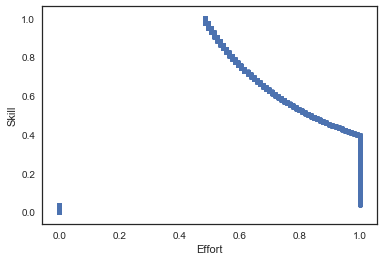

In [20]:
diff_df.plot.scatter('Effort','Skill')

This looks a bit correct - we would expect a negative slope. And since this graph shows only the cases where difficulty is high and success was reached, we might expect only high effort vales to make it through. But I'm not sure what the heavy right hand tail is. Nor the weird blip on the left

/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


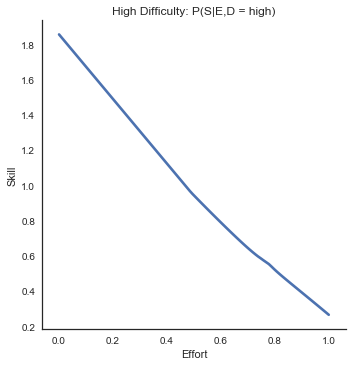

In [22]:
ax = sns.lmplot(x="Effort", y="Skill",scatter=False, ci=None, data=diff_df, lowess=True)
plt.title('High Difficulty: P(S|E,D = high)')
plt.show()

## Create P(S| E = high, D)

In [24]:
def create_priors_highE(n_samples, tao_skill, u_skill, cost, A, B, u_diff = 0.5, tao_diff=1,  reward=1, 
                      threshold=0.5):
    """Model for creating priors of skill at different effort and success thresholds
    
    Parameters
    ----------
    n_samples : int of number of samples
        You want to run

    Returns
    -------
    Ndarray of skill, success trials, and high effort trials
    """
    # Skill and diff are beta distributions.
    skills = np.random.beta(
        tao_skill * u_skill, (1 - u_skill) * tao_skill, size=n_samples,
    )
    
    diff = np.random.beta(tao_diff*u_diff , (1-u_diff)*tao_diff, size=n_samples)
    
    efforts = get_effort_multidim(
        cost=cost, skill=skills, diff=diff, A=A, B=B,
    )
    
    high_effort = efforts > threshold
    success = prob_reward(efforts, diff, skills, A, B) > np.random.random(n_samples)
    
    
    return skills,  success, high_effort, diff

def run_model_highEff(cost, A, B, u_skill, tao_skill, u_diff = 0.5, tao_diff = 1, n_samples=10000):
    """function that takes in free parameters and returns model predictions (predicted skill)
    when difficulty is high only and reward is achieved
    Parameters
    ----------
    """
    
    np.random.seed(0)
    REWARD=1
    
    skills, success, high_effort, difficulty= create_priors_highE(
        n_samples =n_samples, tao_skill=tao_skill, u_skill=u_skill, cost=cost, A=A, B=B,u_diff=u_diff, tao_diff=tao_diff
    )
    

    skill_high_e = skills[high_effort ] # get range of skills when eff is high and success is true
    diff_high_e = difficulty[high_effort ] # get range of effort when eff is high and success is true

    return skill_high_e  , diff_high_e


In [25]:
skill_high_e  , diff_high_e= run_model_highEff(cost = .1, A = 2, B = 9, u_skill = .5, tao_skill = 1,  n_samples=10000) #play with parameters


In [26]:
e = {'Skill':  skill_high_e, 'Difficulty':diff_high_e}
eff_df = pd.DataFrame(data=e)
eff_df.head()

,Difficulty,Skill
0,0.701828,0.370615
1,0.755159,0.550306
2,0.431116,0.300812
3,0.854730,0.194055
4,0.455327,0.399293


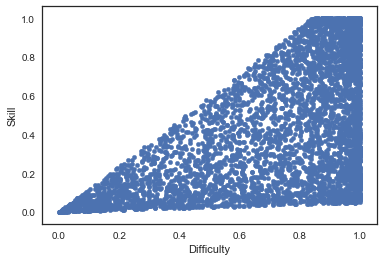

In [27]:
eff_df.plot.scatter('Difficulty','Skill')

/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


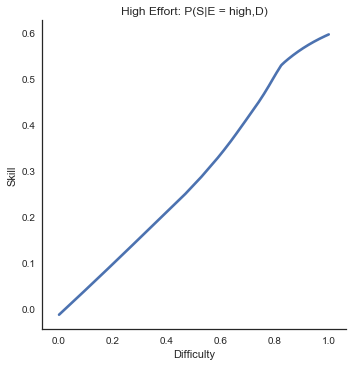

In [28]:
ax = sns.lmplot(x="Difficulty", y="Skill",scatter=False, ci=None, data=eff_df, lowess=True)
plt.title('High Effort: P(S|E = high,D)')
plt.show()

## Plots

#### Determine effort given various skills and difficulties
* planning model

/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


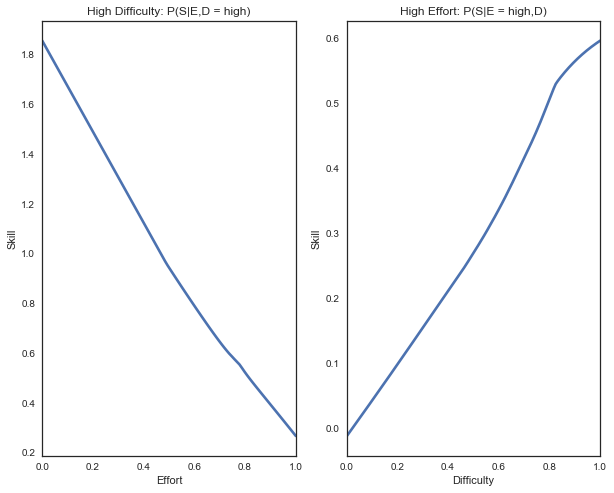

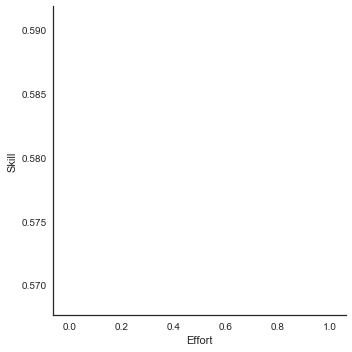

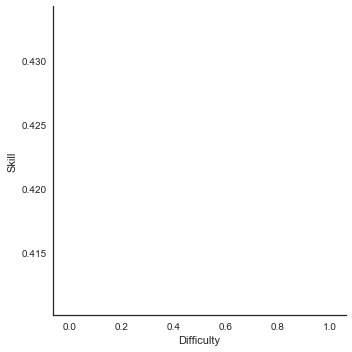

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
sns.lmplot(x="Effort", y="Skill",scatter=False, ci=None, data=diff_df, lowess=True, ax = ax1)
ax1.set_title('High Difficulty: P(S|E,D = high)')
sns.lmplot(x="Difficulty", y="Skill",scatter=False, ci=None, data=eff_df, lowess=True, ax = ax2)
ax2.set_title('High Effort: P(S|E = high,D)')
#plt.show()


## Questions
* Not sure how to get rid of bottom 2 graphs
* Do we like the shape of these?
* Should we scale Skill from 0 - 1?
* Why is there so much more variance in P(S|E =high,D) than P(S|E, D = high) 

## Write Planning Models


### P(S|E, D = high)
Feed in Effort and Difficulty and get skill  - right now we don't have a speicific input of effort. 